1/1 [==============================] - 0s 25ms/step
1) Test RMSE: 175.241
1/1 [==============================] - 0s 22ms/step
2) Test RMSE: 231.032
1/1 [==============================] - 0s 36ms/step
3) Test RMSE: 192.590
1/1 [==============================] - 0s 17ms/step
4) Test RMSE: 198.993
1/1 [==============================] - 0s 24ms/step
5) Test RMSE: 186.006
1/1 [==============================] - 0s 28ms/step
6) Test RMSE: 177.505
1/1 [==============================] - 0s 24ms/step
7) Test RMSE: 176.015
1/1 [==============================] - 0s 26ms/step
8) Test RMSE: 181.127
1/1 [==============================] - 0s 21ms/step
9) Test RMSE: 181.729
1/1 [==============================] - 0s 18ms/step
10) Test RMSE: 177.081
             rmse
count   10.000000
mean   187.731995
std     17.059710
min    175.241498
25%    177.187293
50%    181.428069
75%    190.943581
max    231.032413


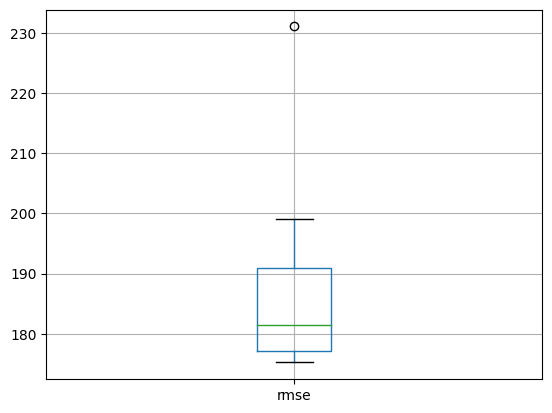

In [5]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import pandas as pd

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset

data= pd.read_excel('New data.xlsx', sheet_name='Data') 
series = data['Bãi Cháy']

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-36], supervised_values[-36:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# repeat experiment
repeats = 10
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-36:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

In [40]:
import pandas as pd
import numpy as np
data= pd.read_excel('New data.xlsx', sheet_name='Data') 
series = data['Bãi Cháy']
A.append(series[i::12].values for i in range(12))
A[:252]

[5.0,
 49.0,
 27.0,
 4.0,
 2.0,
 4.0,
 79.0,
 0.8,
 140.9,
 2.7,
 41.7,
 35.9,
 1.0,
 36.1,
 181.0,
 26.4,
 18.0,
 18.9,
 72.9,
 40.8,
 69.7,
 21.0,
 17.0,
 30.0,
 25.0,
 10.0,
 21.0,
 26.0,
 20.2,
 10.2,
 14.8,
 15.0,
 9.9,
 21.9,
 35.6,
 3.4,
 53.3,
 5.2,
 25.4,
 25.3,
 58.3,
 144.8,
 12.0,
 16.0,
 20.0,
 29.0,
 48.0,
 31.0,
 73.0,
 55.6,
 5.2,
 60.4,
 34.0,
 119.4,
 58.8,
 23.1,
 18.8,
 45.1,
 39.4,
 32.5,
 37.3,
 39.2,
 49.3,
 17.0,
 87.0,
 72.0,
 27.0,
 43.0,
 44.0,
 39.0,
 133.6,
 125.3,
 35.7,
 98.2,
 67.1,
 148.1,
 26.8,
 204.5,
 38.9,
 44.2,
 185.4,
 48.4,
 51.1,
 24.7,
 413.0,
 331.0,
 243.0,
 247.0,
 49.0,
 100.0,
 189.0,
 223.6,
 196.8,
 199.1,
 434.9,
 220.1,
 36.9,
 187.2,
 205.9,
 171.1,
 102.5,
 159.2,
 67.7,
 42.9,
 291.7,
 368.0,
 413.0,
 92.0,
 340.0,
 198.0,
 297.0,
 380.0,
 213.1,
 342.7,
 289.2,
 121.9,
 368.2,
 296.4,
 255.9,
 211.5,
 351.7,
 309.4,
 274.9,
 141.8,
 187.0,
 182.9,
 319.0,
 187.0,
 516.0,
 628.0,
 464.0,
 410.0,
 206.0,
 320.6,
 174.5,
 318.6,
 42

In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import pandas as pd

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset

data= pd.read_excel('New data.xlsx', sheet_name='Data') 
series = data['Bãi Cháy']

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# repeat experiment
repeats = 20
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 100, 1)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

1/1 [==============================] - 0s 21ms/step
1) Test RMSE: 157.496
1/1 [==============================] - 0s 30ms/step
2) Test RMSE: 156.526
1/1 [==============================] - 0s 24ms/step
3) Test RMSE: 158.151
1/1 [==============================] - 0s 27ms/step
4) Test RMSE: 159.344
1/1 [==============================] - 0s 21ms/step
5) Test RMSE: 157.799
1/1 [==============================] - 0s 21ms/step
6) Test RMSE: 157.875
1/1 [==============================] - 0s 20ms/step
7) Test RMSE: 157.674
1/1 [==============================] - 0s 32ms/step
8) Test RMSE: 157.216
1/1 [==============================] - 0s 48ms/step
9) Test RMSE: 181.639
1/1 [==============================] - 0s 20ms/step
10) Test RMSE: 183.096
1/1 [==============================] - 0s 22ms/step
11) Test RMSE: 157.188
1/1 [==============================] - 0s 19ms/step
12) Test RMSE: 156.359
1/1 [==============================] - 0s 22ms/step
13) Test RMSE: 157.223
1/1 [=============================

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import pandas as pd

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset

data= pd.read_excel('New data.xlsx', sheet_name='Data') 
series = data['Vũng Tàu']

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# repeat experiment
repeats = 20
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 50, 1)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)

# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()